In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from itertools import product
import xarray 
import warnings
warnings.filterwarnings('ignore')

def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(*params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def pade4_2(x,A,U1,D1,U2,D2,D3,D4):
    return (U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def pade4_3(x,A,B,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+B)

def order1(x,M1):
    return M1*x/(x-M1*x**2)

def order2(x,M1,M2):
    return (M1*x-M2/2*x**2)/(x-M1*x**2+M2/2*x**3)

def order3(x,M1,M2,M3):
    return (M1*x-M2/2*x**2+M3/6*x**3)/(x-M1*x**2+M2/2*x**3-M3/6*x**4)

def order4(x,M1,M2,M3,M4):
    Tr = 1-M1*x+M2/2*x**2-M3/6*x**3+M4/24*x**4
    return (1-Tr)/(Tr*x)

def order5(x,M1,M2,M3,M4,M5):
    Tr = 1-M1*x+M2/2*x**2-M3/6*x**3+M4/24*x**4-M5/100*x**5
    return (1-Tr)/(Tr*x)

def padeTr4_3(x,A,U1,D1,U2,D2,U3,D3,D4):
    Tr = (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)
    return (1-Tr)/(Tr*x)

def FrechetLaplace(rs,**kwargs):
    return 2*np.sqrt(rs)*scp.special.kn(1,2*np.sqrt(rs))

def GammaLaplace(rs,k,theta):
    return (1+rs*theta)**(-k)

# General procedure:

1. Exact mean values with different rates are found using: $\langle T\left(r\right) \rangle = \frac{1-\tilde{T}(r)}{r\tilde{T}(r)}$

2. The function $\langle T\left(r\right) \rangle$ is evaluated using different fits to the selected points.

3. The evaluated value at a selected reference point is compared to the exact value at this point.

4. The same process is repeated, using sampled mean values instead of exact values as selected points for the fit.

## Frechet distribution

The selected distribution: $Pr(t) = t^{-2}exp\left(-t^{-1}\right)$.

The mean and standard deviation diverge; we will compare to $\langle T\left(0.001\right) \rangle = 6.8$.

The Laplace transform may be found using the modified Bessel function: $\tilde{T}(r)=2\sqrt{r}K_1\left(2\sqrt{r}\right)$ (https://aip.scitation.org/doi/10.1063/1.4893338).

## Gamma distribution

The selected distribution: $Pr(t) = \frac{1}{\Gamma(k)\theta^k}t^{k-1}exp\left(-\frac{t}{\theta}\right)$.

$\mu = k\theta$, $\sigma = \sqrt{k}\theta$, $\tilde{T}(r)=(1+\theta r)^{-k}$

We chose $k=0.25$, $\theta=25$, which leads to $CV=\frac{\sigma}{\mu}=\frac{1}{\sqrt{k}}=2$

Text(0.75, 9, 'Gamma')

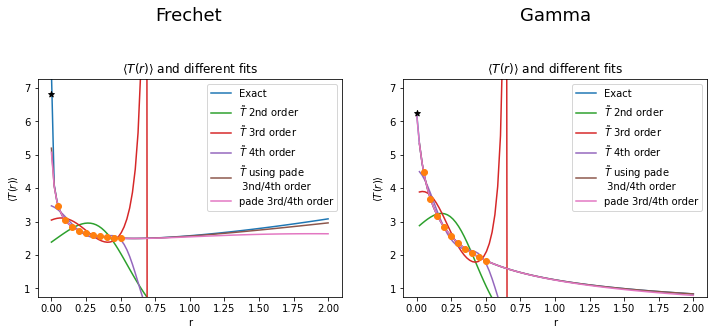

In [2]:
k = 0.25
theta = 25
fig, axs = plt.subplots(1,2,figsize=(12,4))
refs = [0.001,0.00000001]
TrRef = 2*np.sqrt(refs[0])*scp.special.kn(1,2*np.sqrt(refs[0]))
muRef = [(1-TrRef)/(refs[0]*TrRef),k*theta]
funcs = [FrechetLaplace,GammaLaplace]
refStarts = [0.0005,0] 

for i in range(2):
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selrs = np.linspace(0.05,0.5,10)
    selTrs = funcs[i](selrs,k=k,theta=theta)
    selmus = (1-selTrs)/(selrs*selTrs)
    axs[i].plot(selrs,selmus,"o",zorder=10)

    # Fits

    for func,label in zip([order2,order3,order4,padeTr4_3,pade4_3],
                          [r"$\tilde{T}$ 2nd order",r"$\tilde{T}$ 3rd order",r"$\tilde{T}$ 4th order",r"$\tilde{T}$"+" using pade \n 3nd/4th order","pade 3rd/4th order"]):
        fit = scp.optimize.curve_fit(func, selrs, selmus,bounds=(0,np.inf))
        axs[i].plot(rs,func(rs,*fit[0]),label=label)
    axs[i].set_ylim(0.75,7.25)
    axs[i].legend()
    axs[i].set_xlabel("r")
    axs[i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[i].set_title(r"$\langle T\left(r\right) \rangle$ and different fits")
axs[0].text(0.75,9,"Frechet",fontsize=18)
axs[1].text(0.75,9,"Gamma",fontsize=18)

Tried different fitting functions using the orange exact points on the function $\langle T\left(r\right) \rangle$:

1. Evaluating $\tilde{T}$ in the expression $\langle T\left(r\right) \rangle = \frac{1-\tilde{T}(r)}{r\tilde{T}(r)}$
using a Taylor expansion fits very poorly.

2. Evaluating $\tilde{T}$ in this expression using a Pade function, and evaluating $\langle T\left(r\right) \rangle$
directly using a Pade of the same order, fits well.

We will use the Pade fit for $\tilde{T}$ in the next plots.

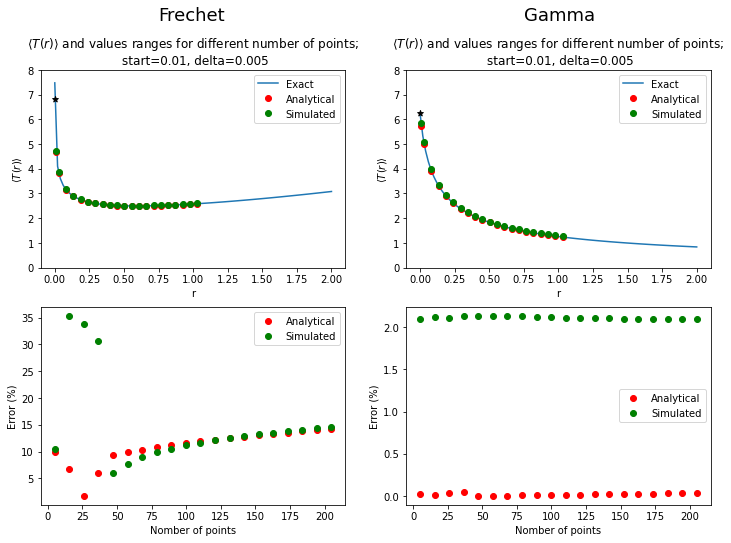

In [6]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
sampleFuncs = [scp.stats.invweibull.rvs,np.random.gamma]
sampleParams = [[1],[k,theta]]
axs[0][0].text(0.75,10,"Frechet",fontsize=18)
axs[0][1].text(0.75,10,"Gamma",fontsize=18)
start = 0.01
delta = 0.005
repeats = 10000
pointslist = np.linspace(5,205,20)
fitFunction = padeTr4_3

for i in range(2):
    axs[0][i].set_ylim(0,8)
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[0][i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[0][i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selrs = np.array([start]+[start + delta*(p-1) for p in pointslist])
    selTrs = funcs[i](selrs,k=k,theta=theta)
    selmus = (1-selTrs)/(selrs*selTrs)
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="red",label="Analytical")
    axs[0][i].set_xlabel("r")
    axs[0][i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[0][i].set_title(r"$\langle T\left(r\right) \rangle$ and values ranges for different number of points;"+f"\n start={start}, delta={delta}")

    # Simulated

    samples = np.array([sample(sampleFuncs[i],sampleParams[i],start) for j in range(repeats)])
    selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
    selmus = (1-selTrs)/((selrs-start)*selTrs)
    selmus[0] = samples.mean()
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="green",label="Simulated")
    axs[0][i].legend()

    # predictions
    errorsA = []
    errorsS = []
    for points in pointslist:
        selrs = np.linspace(start,start+delta*(points-1),int(points))
        selTrs = funcs[i](selrs,k=k,theta=theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        fit = scp.optimize.curve_fit(fitFunction, selrs, selmus,bounds=(0,np.inf))
        pre = fitFunction(refs[i],*fit[0])
        errorsA.append(abs(pre-muRef[i])/muRef[i]*100)
        selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
        selmus = (1-selTrs)/((selrs-start)*selTrs)
        selmus[0] = samples.mean()
        fit = scp.optimize.curve_fit(fitFunction, selrs, selmus,bounds=(0,np.inf))
        pre = fitFunction(refs[i],*fit[0])
        errorsS.append(abs(pre-muRef[i])/muRef[i]*100)
    axs[1][i].plot(pointslist,errorsA,"o",c="red",label="Analytical")
    axs[1][i].plot(pointslist,errorsS,"o",c="green",label="Simulated")
    axs[1][i].set_xlabel("Nomber of points")
    axs[1][i].set_ylabel("Error (%)")
    axs[1][i].legend()

Repeated the prediction process for the same reset rate $r=0.01$ and delta "jumps" forwards,
with different number of "jumps". This number doesn't seem to have a significant influence on the error
in the chosen region.

Simulated and analytical points for the fit yeald similar results.

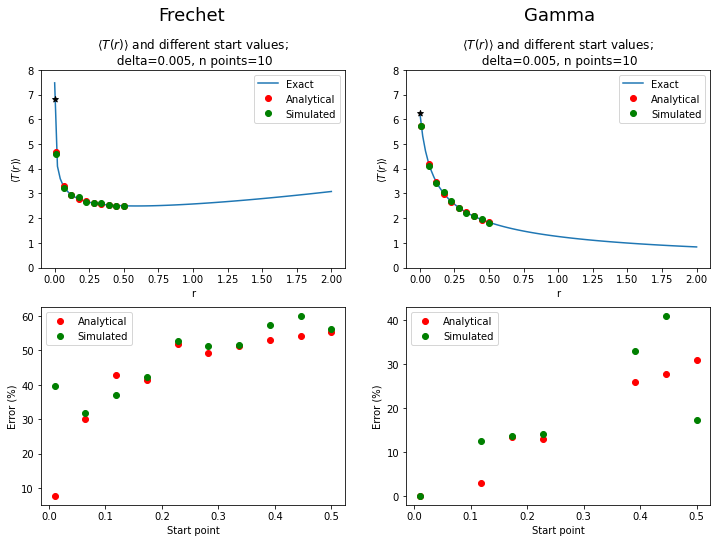

In [8]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0][0].text(0.75,10,"Frechet",fontsize=18)
axs[0][1].text(0.75,10,"Gamma",fontsize=18)
startlist = np.linspace(0.01,0.5,10)
points = 10

for i in range(2):
    axs[0][i].set_ylim(0,8)
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[0][i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[0][i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selTrs = funcs[i](startlist,k=k,theta=theta)
    selmus = (1-selTrs)/(startlist*selTrs)
    axs[0][i].plot(startlist,selmus,"o",zorder=10,c="red",label="Analytical")
    axs[0][i].set_xlabel("r")
    axs[0][i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[0][i].set_title(r"$\langle T\left(r\right) \rangle$ and different start values;"+f"\n delta={delta}, n points={points}")

    # Simulated
    sampleList = []
    for start in startlist:
        sampleList.append(np.array([sample(sampleFuncs[i],sampleParams[i],start) for j in range(repeats)]))
    axs[0][i].plot(startlist,[sample.mean() for sample in sampleList],"o",zorder=10,c="green",label="Simulated")
    axs[0][i].legend()

    # predictions
    errorsA = []
    errorsS = []
    for start,samples in zip(startlist,sampleList):
        selrs = np.linspace(start,start+delta*(points-1),int(points))
        selTrs = funcs[i](selrs,k=k,theta=theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        try:
            fit = scp.optimize.curve_fit(padeTr4_3, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_3(refs[i],*fit[0])
        except:
            pre = np.inf 
        errorsA.append(abs(pre-muRef[i])/muRef[i]*100)
        selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
        selmus = (1-selTrs)/((selrs-start)*selTrs)
        selmus[0] = samples.mean()
        try:
            fit = scp.optimize.curve_fit(padeTr4_3, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_3(refs[i],*fit[0])
        except:
            pre = np.inf 
        errorsS.append(abs(pre-muRef[i])/muRef[i]*100)
    axs[1][i].plot(startlist,errorsA,"o",c="red",label="Analytical")
    axs[1][i].plot(startlist,errorsS,"o",c="green",label="Simulated")
    axs[1][i].set_xlabel("Start point")
    axs[1][i].set_ylabel("Error (%)")
    axs[1][i].legend()

Repeated the prediction process for the same delta and number for "jumps" forwards,
with different starting rates. As predicted, the error increases significantly as the starting rate increases.

Simulated and analytical points for the fit yeald similar results.

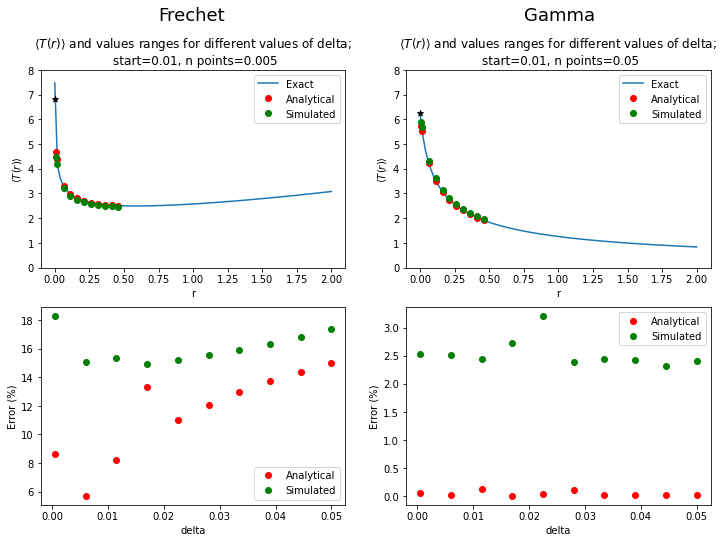

In [9]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0][0].text(0.75,10,"Frechet",fontsize=18)
axs[0][1].text(0.75,10,"Gamma",fontsize=18)
start = 0.01
deltalist = np.linspace(0.0005,0.05,10)
repeats = 10000

for i in range(2):
    axs[0][i].set_ylim(0,8)
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[0][i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[0][i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selrs = np.array([start]+[start + delta*9 for delta in deltalist])
    selTrs = funcs[i](selrs,k=k,theta=theta)
    selmus = (1-selTrs)/(selrs*selTrs)
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="red",label="Analytical")
    axs[0][i].set_xlabel("r")
    axs[0][i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[0][i].set_title(r"$\langle T\left(r\right) \rangle$ and values ranges for different values of delta;"+f"\n start={start}, n points={delta}")

    # Simulated

    samples = np.array([sample(sampleFuncs[i],sampleParams[i],start) for j in range(repeats)])
    selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
    selmus = (1-selTrs)/((selrs-start)*selTrs)
    selmus[0] = samples.mean()
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="green",label="Simulated")
    axs[0][i].legend()

    # predictions
    errorsA = []
    errorsS = []
    for delta in deltalist:
        selrs = np.linspace(start,start+delta*(points-1),int(points))
        selTrs = funcs[i](selrs,k=k,theta=theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        try:
            fit = scp.optimize.curve_fit(padeTr4_3, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_3(refs[i],*fit[0])
        except:
            pre = np.inf 
        errorsA.append(abs(pre-muRef[i])/muRef[i]*100)
        selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
        selmus = (1-selTrs)/((selrs-start)*selTrs)
        selmus[0] = samples.mean()
        try:
            fit = scp.optimize.curve_fit(padeTr4_3, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_3(refs[i],*fit[0])
        except:
            pre = np.inf 
        errorsS.append(abs(pre-muRef[i])/muRef[i]*100)
    axs[1][i].plot(deltalist,errorsA,"o",c="red",label="Analytical")
    axs[1][i].plot(deltalist,errorsS,"o",c="green",label="Simulated")
    axs[1][i].set_xlabel("delta")
    axs[1][i].set_ylabel("Error (%)")
    axs[1][i].legend()

Repeated the prediction process for the same reset rate $r=0.01$ and number "jumps" forwards,
with different delta values for the "jumps". These values don't seem to have a significant influence on the error
in the chosen region.

Simulated and analytical points for the fit yeald similar results.

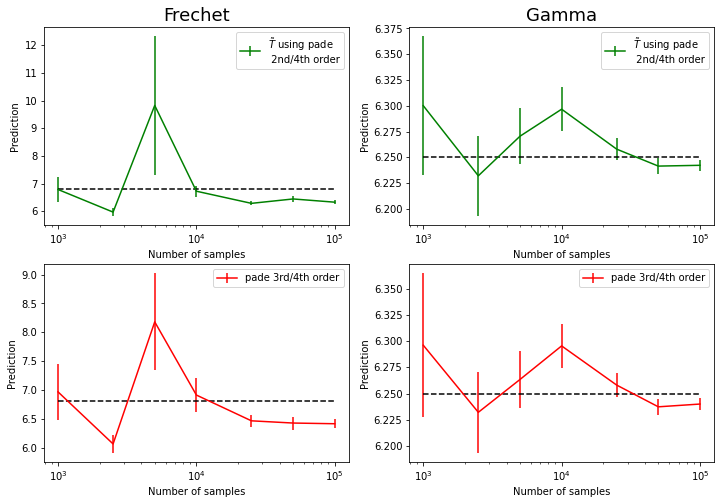

In [14]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0][0].set_title("Frechet",fontsize=18)
axs[0][1].set_title("Gamma",fontsize=18)

start = 0.01
points = 10
delta = 0.005
repeatList = [1000,2500,5000,10000,25000,50000,100000]
selrs = np.linspace(start,start+delta*(points-1),int(points))
for i in range(2):
    predictionsP = []
    predictionsT = []
    errorsP = []
    errorsT = []
    for repeats in repeatList:
        presP = []
        presT = []
        for j in range(50):
            samples = np.array([sample(sampleFuncs[i],sampleParams[i],start) for k in range(repeats)])
            selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
            selmus = (1-selTrs)/((selrs-start)*selTrs)
            selmus[0] = samples.mean()
            try:
                fit = scp.optimize.curve_fit(padeTr4_3, selrs, selmus,bounds=(0,np.inf))
                pre = padeTr4_3(refs[i],*fit[0])
                if pre>0:
                    presT.append(pre)
            except:
                pass
            try:
                fit = scp.optimize.curve_fit(pade4_3, selrs, selmus,bounds=(0,np.inf))
                pre = pade4_3(refs[i],*fit[0])
                if pre > 0:
                    presP.append(pre)
            except:
                pass
        predictionsT.append(np.mean(presT))
        errorsT.append(np.std(presT)/np.sqrt(len(presT)))
        predictionsP.append(np.mean(presP))
        errorsP.append(np.std(presP)/np.sqrt(len(presP)))
    axs[0][i].errorbar(repeatList,predictionsT,errorsT,c="green",label=r"$\tilde{T}$"+" using pade \n 2nd/4th order")
    axs[1][i].errorbar(repeatList,predictionsP,errorsP,c="red",label="pade 3rd/4th order")
    for j in range(2):
        axs[j][i].plot([min(repeatList),max(repeatList)],[muRef[i],muRef[i]],c="black",linestyle="dashed")
        axs[j][i].set_xscale("log")
        axs[j][i].set_xlabel("Number of samples")
        axs[j][i].set_ylabel("Prediction")
        axs[j][i].legend()

Made predictions using different number of samples. Repeated each number of samples 50 times to get the error of the prediction.
The calculated error decreases with the number of samples, but the prediction doesn't always converge to the analytical value.

Evaluating $\tilde{T}$ using a Pade function, and evaluating $\langle T\left(r\right) \rangle$
using a Pade gives similar results.